# OOL Example


This notebook implements the OmicsMind pipeline for OOL dataset:
- `CyTOF.csv`
- `Metabolomics.csv`
- `Proteomics.csv`

In [1]:
# !pip -q install pandas numpy scikit-learn tqdm torch

import os, random, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from omicsmind.data import load_omics_table, MultiOmicsDataset, compute_nrmse_numpy,plot_rmse_nrmse_pies
from omicsmind.omicsmind import ModalityVAE, CrossOmicsTransformer, OmicsMind, omicsmind_loss

print("torch:", torch.__version__)


torch: 2.5.1+cu121


## 1. Load data tables

In [2]:
data_dir = "./data/OOL_half_train"   
files = {
    "CyTOF": "CyTOF.csv",
    "Metabolomics": "Metabolomics.csv",
    "Proteomics": "Proteomics.csv",
}

modalities = {}
missing_files = []
for k, fn in files.items():
    p = os.path.join(data_dir, fn)
    if os.path.exists(p):
        modalities[k] = load_omics_table(p)
        print(k, "loaded", modalities[k].shape)
    else:
        missing_files.append(p)

if missing_files:
    print("\n[WARN] Missing files, will use synthetic data:", missing_files)


CyTOF loaded (75, 1502)
Metabolomics loaded (75, 3529)
Proteomics loaded (75, 1317)


## 2. If files are missing, generate synthetic data(Optional)


In [3]:
if missing_files:
    np.random.seed(0)
    n = 80
    modalities = {
        "rna":  pd.DataFrame(np.random.randn(n, 2000), index=[f"S{i:03d}" for i in range(n)]),
        "rppa": pd.DataFrame(np.random.randn(n, 200),  index=[f"S{i:03d}" for i in range(n)]),
        "meth": pd.DataFrame(np.random.randn(n, 1000), index=[f"S{i:03d}" for i in range(n)]),
    }
    # Simulate block-wise missingness
    idx = modalities["rna"].index
    mask_rppa = np.random.choice(idx, size=int(0.3*n), replace=False)
    mask_meth = np.random.choice(idx, size=int(0.2*n), replace=False)
    modalities["rppa"].loc[mask_rppa] = np.nan
    modalities["meth"].loc[mask_meth] = np.nan

    print("Synthetic modalities:", {k:v.shape for k,v in modalities.items()})


## 3. Sample alignment + z-score normalization


In [4]:
omics_keys = list(files.keys())
all_samples = sorted(set().union(*[modalities[k].index for k in omics_keys]))

def align(df): 
    return df.reindex(all_samples)

modalities_aligned = {k: align(modalities[k]) for k in omics_keys}

def zscore(df):
    mu = df.mean(axis=0, skipna=True)
    sd = df.std(axis=0, skipna=True).replace(0, 1.0)
    return (df - mu) / sd

modalities_aligned = {k: zscore(v) for k,v in modalities_aligned.items()}

X = {k: v.to_numpy(dtype=np.float32) for k,v in modalities_aligned.items()}
print({k: X[k].shape for k in X})


{'CyTOF': (75, 1502), 'Metabolomics': (75, 3529), 'Proteomics': (75, 1317)}


## 4. Dataset for block-wise masked-modality training


In [5]:

dataset = MultiOmicsDataset(X, mask_prob=0.3)
loader = DataLoader(dataset, batch_size=16, shuffle=True)


## 5. Training


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
in_dims = {m: X[m].shape[1] for m in X}

model = OmicsMind(in_dims, z_dim=64).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

def to_tensor_batch(batch):
    sample, observed, train_mask = batch
    batch_x = {m: torch.tensor(sample[m], device=device) for m in sample}
    observed_t = {m: torch.tensor(observed[m], device=device) for m in observed}
    train_mask_t = {m: torch.tensor(train_mask[m], device=device) for m in train_mask}
    return batch_x, observed_t, train_mask_t

epochs = 200
for ep in range(1, epochs+1):
    model.train()
    total = total_rec = total_kl = 0.0
    for batch in loader:
        bx, obs_t, mask_t = to_tensor_batch(batch)
        refined_xhat, mus, logvars = model(bx, mask_t)
        loss, rec, kl = omicsmind_loss(bx, refined_xhat, mus, logvars, obs_t, mask_t, only_masked=False)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total += loss.item(); total_rec += rec.item(); total_kl += kl.item()

    if ep % 5 == 0 or ep == 1:
        print(f"Epoch {ep:03d} | loss={total/len(loader):.4f} rec={total_rec/len(loader):.4f} kl={total_kl/len(loader):.4f}")


Epoch 001 | loss=3.0486 rec=3.0458 kl=2.7660
Epoch 005 | loss=2.9518 rec=2.9502 kl=1.6301
Epoch 010 | loss=2.8929 rec=2.8810 kl=11.8884
Epoch 015 | loss=2.8174 rec=2.7924 kl=24.9530
Epoch 020 | loss=2.7050 rec=2.6623 kl=42.7126
Epoch 025 | loss=2.5962 rec=2.5497 kl=46.4646
Epoch 030 | loss=2.5106 rec=2.4561 kl=54.4752
Epoch 035 | loss=2.4577 rec=2.3878 kl=69.8693
Epoch 040 | loss=2.3323 rec=2.2507 kl=81.5506
Epoch 045 | loss=2.2569 rec=2.1853 kl=71.6491
Epoch 050 | loss=2.9980 rec=2.0680 kl=929.9979
Epoch 055 | loss=2.0854 rec=1.9761 kl=109.2586
Epoch 060 | loss=2.2281 rec=2.1082 kl=119.9106
Epoch 065 | loss=2.2102 rec=2.0995 kl=110.6348
Epoch 070 | loss=1.8388 rec=1.7380 kl=100.7578
Epoch 075 | loss=2.0177 rec=1.8958 kl=121.9358
Epoch 080 | loss=1.8783 rec=1.7443 kl=134.0361
Epoch 085 | loss=1.8193 rec=1.6597 kl=159.5573
Epoch 090 | loss=1.6768 rec=1.5440 kl=132.8134
Epoch 095 | loss=1.5825 rec=1.4471 kl=135.4039
Epoch 100 | loss=1.6474 rec=1.5118 kl=135.5818
Epoch 105 | loss=1.6104 r

## 6. Full imputation and CSV export


In [11]:

impute_data_dir = "./data/OOL_raw"  # Change this! Points to the dataset for imputation.

print("="*60)
print("LOADING DATA TO IMPUTE (ORDER-PRESERVING)")
print("="*60)
print(f"Data directory: {impute_data_dir}\n")

# ---- Load raw data to be imputed (preserving original row order) ----
impute_modalities = {}
for k, fn in files.items():
    p = os.path.join(impute_data_dir, fn)
    if os.path.exists(p):
        df = load_omics_table(p)

        impute_modalities[k] = df.copy()

        print(f"✓ {k} loaded from {fn}, shape: {df.shape}")
        print(f"  → Block-missing rows:  {df.isna().all(axis=1).sum()}")
        print(f"  → Total missing values: {df.isna().sum().sum()}")
    else:
        raise FileNotFoundError(f"Required file not found: {p}")


# ---- Merge sample IDs from all modalities while preserving original order ----
def union_preserve_order(list_of_indices):
    seen = set()
    output = []
    for idx_list in list_of_indices:
        for x in idx_list:
            if x not in seen:
                output.append(x)
                seen.add(x)
    return output

# Use raw indices from all modalities, without sorting
impute_samples = union_preserve_order([
    impute_modalities[k].index.tolist() for k in omics_keys
])

print("\nTotal samples to impute:", len(impute_samples))
print("Sample order preserved.\n")


# ---- Align all modalities to the same sample order (no sorting) ----
impute_aligned = {
    k: impute_modalities[k].reindex(impute_samples)
    for k in omics_keys
}


# ---- Extract normalization parameters from training data ----
print("="*60)
print("EXTRACTING TRAINING NORMALIZATION PARAMS")
print("="*60)

normalization_params = {}
for k in omics_keys:
    train_df = modalities[k]  # Training data modality (original scale)
    mu = train_df.mean(axis=0, skipna=True)
    sd = train_df.std(axis=0, skipna=True).replace(0, 1.0)
    normalization_params[k] = {'mean': mu, 'std': sd}
    print(f"{k}: mean/std loaded (shape {mu.shape})")


# ---- Normalize imputation data using training parameters (order preserved) ----
print("\nApplying training normalization to imputation data...")

impute_normalized = {}
for k in omics_keys:
    mu = normalization_params[k]['mean']
    sd = normalization_params[k]['std']
    impute_normalized[k] = (impute_aligned[k] - mu) / sd
    print(f"✓ {k} normalized using training params")


# ---- Convert to numpy arrays ----
X_impute = {
    k: impute_normalized[k].to_numpy(dtype=np.float32)
    for k in omics_keys
}

print("\nData normalization complete.\n")


# ---- Build dataset without altering sample order ----
model.eval()

class ImputationDataset(Dataset):
    def __init__(self, X_dict):
        self.mods = list(X_dict.keys())
        self.X = X_dict
        self.n = next(iter(X_dict.values())).shape[0]
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        sample, observed = {}, {}
        for m in self.mods:
            x_m = self.X[m][idx]
            # block missing?
            obs_m = not np.all(np.isnan(x_m))   
            observed[m] = obs_m
            sample[m] = np.nan_to_num(x_m, nan=0.0)
        return sample, observed, idx


impute_dataset = ImputationDataset(X_impute)
impute_loader = DataLoader(impute_dataset, batch_size=16, shuffle=False)


# ---- Perform imputation ----
print("="*60)
print("IMPUTING MISSING MODALITIES (ORDER PRESERVED)")
print("="*60)

imputed_X = {m: X_impute[m].copy() for m in omics_keys}

with torch.no_grad():
    for sample, observed, indices in tqdm(impute_loader, desc="Imputation"):
        batch_x = {m: torch.tensor(sample[m], device=device) for m in sample}
        observed_t = {m: torch.tensor(observed[m], device=device) for m in observed}

        # Mask: 1 = observed; 0 = block-missing
        infer_mask = {m: observed_t[m].float() for m in observed_t}

        refined_xhat, _, _ = model(batch_x, infer_mask)

        # Write predictions back into imputed_X
        for i, global_idx in enumerate(indices):
            for m in omics_keys:
                if not observed[m][i]:
                    imputed_X[m][global_idx] = refined_xhat[m][i].cpu().numpy()


# ---- Denormalize results back to original scale ----
print("\nDenormalizing imputed values...")

imputed_original_scale = {}
for m in omics_keys:
    mu = normalization_params[m]['mean'].values
    sd = normalization_params[m]['std'].values
    restored = imputed_X[m] * sd + mu

    imputed_original_scale[m] = pd.DataFrame(
        restored,
        index=impute_samples,                 
        columns=impute_aligned[m].columns   
    )

    print(f"{m}: restored to original scale\n")


# ---- Merge original and imputed values (overwrite ONLY NaNs) ----
print("="*60)
print("MERGING ORIGINAL AND IMPUTED VALUES")
print("="*60)

final_data = {}

for m in omics_keys:
    original = impute_aligned[m]    
    imputed  = imputed_original_scale[m]

    # Keep original observed values; fill only NaNs
    final = original.combine_first(imputed)

    final_data[m] = final

    print(f"{m}: NaNs before = {original.isna().sum().sum()}, after = {final.isna().sum().sum()}")


# ---- Export results ----
output_dir = "./imputed_results/OOL_imputed"
os.makedirs(output_dir, exist_ok=True)

print("\nExporting final CSVs...")

for m in omics_keys:
    out = os.path.join(output_dir, f"{m}.csv")
    final_data[m].to_csv(out)
    print(f"✓ Saved {out}  (shape {final_data[m].shape})")

print("\nAll imputation complete. Original sample order preserved!")


LOADING DATA TO IMPUTE (ORDER-PRESERVING)
Data directory: ./data/OOL_raw

✓ CyTOF loaded from CyTOF.csv, shape: (150, 1502)
  → Block-missing rows:  25
  → Total missing values: 37674
✓ Metabolomics loaded from Metabolomics.csv, shape: (150, 3529)
  → Block-missing rows:  23
  → Total missing values: 81167
✓ Proteomics loaded from Proteomics.csv, shape: (150, 1317)
  → Block-missing rows:  27
  → Total missing values: 35559

Total samples to impute: 150
Sample order preserved.

EXTRACTING TRAINING NORMALIZATION PARAMS
CyTOF: mean/std loaded (shape (1502,))
Metabolomics: mean/std loaded (shape (3529,))
Proteomics: mean/std loaded (shape (1317,))

Applying training normalization to imputation data...
✓ CyTOF normalized using training params
✓ Metabolomics normalized using training params
✓ Proteomics normalized using training params

Data normalization complete.

IMPUTING MISSING MODALITIES (ORDER PRESERVED)


Imputation: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 86.35it/s]



Denormalizing imputed values...
CyTOF: restored to original scale

Metabolomics: restored to original scale

Proteomics: restored to original scale

MERGING ORIGINAL AND IMPUTED VALUES
CyTOF: NaNs before = 37674, after = 124
Metabolomics: NaNs before = 81167, after = 0
Proteomics: NaNs before = 35559, after = 0

Exporting final CSVs...
✓ Saved ./imputed_results/OOL_imputed\CyTOF.csv  (shape (150, 1502))
✓ Saved ./imputed_results/OOL_imputed\Metabolomics.csv  (shape (150, 3529))
✓ Saved ./imputed_results/OOL_imputed\Proteomics.csv  (shape (150, 1317))

All imputation complete. Original sample order preserved!


## 7. RMSE and NRMSE Analysis

This is a simulated block-missing data, so we are able to compare the imputed data with the original data using RMSE and NRMSE analysis.

In [16]:
gt_data_dir = "./data/OOL_ori"

def calculate_rmse_nrmse(gt_data_dir):
    gt_modalities = {}
    for k, fn in files.items():
        p = os.path.join(gt_data_dir, fn)
        df = load_omics_table(p)
        gt_modalities[k] = df.loc[impute_samples, impute_aligned[k].columns]
    results = {}
    for m in omics_keys:
        gt_df = gt_modalities[m]
        pred_df = imputed_original_scale[m]
    
        rmse_val, nrmse_val = compute_nrmse_numpy(gt_df, pred_df)
        results[m] = {"RMSE": rmse_val, "NRMSE": nrmse_val}
        print(f"{m}: RMSE={rmse_val:.4f}, NRMSE={nrmse_val:.4f}")
    return results
        
results = calculate_rmse_nrmse(gt_data_dir)

CyTOF: RMSE=0.2434, NRMSE=0.0915
Metabolomics: RMSE=0.5319, NRMSE=0.1804
Proteomics: RMSE=0.2658, NRMSE=0.1128


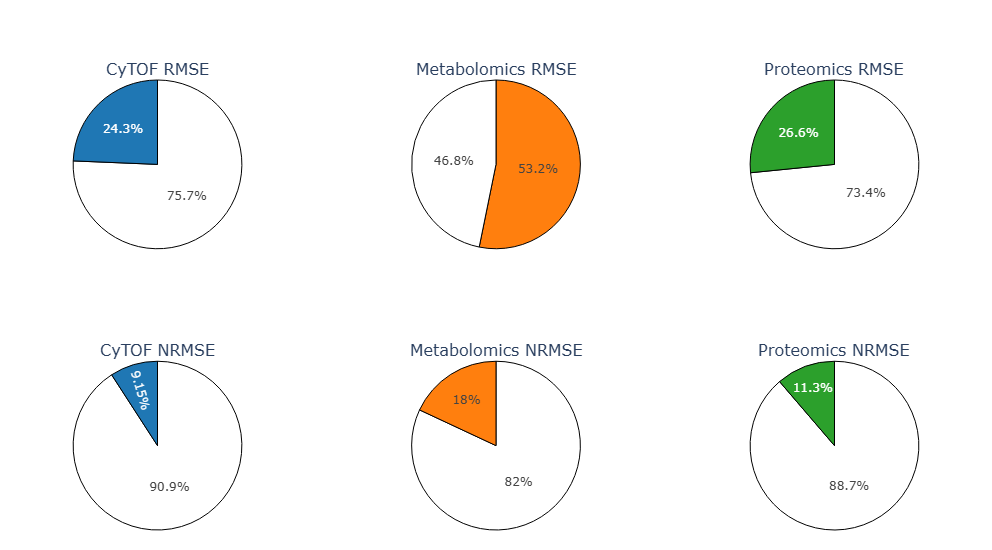

In [17]:
plot_rmse_nrmse_pies(results)